In [1]:
from IPython.core.display import display, HTML
# Full display of notebook (width of screen)
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import basic libraries
import os, glob, sys
import numpy as np   
import pandas as pd 

# Define librearies needed for analysis
import matplotlib.pyplot as plt # Matplotlibrary
import seaborn as sns # Seaborn Library

# Plotting pretty figures
import itertools
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size']       = 19
plt.rcParams['figure.figsize']  = (12.0, 7.0)
plt.rcParams['lines.linewidth'] = 2

SMALL_SIZE = 19
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font',  size = SMALL_SIZE)
plt.rc('axes',  titlesize = MEDIUM_SIZE)
plt.rc('xtick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('axes',  linewidth = 2)

params = {
            'xtick.major.width': 2.15,
            'xtick.minor.width': 1.25,
            'xtick.major.size': 8,
            'xtick.minor.size': 3.5,
            'ytick.major.width': 2.15,
            'ytick.minor.width': 1.25,
            'ytick.major.size': 8,
            'ytick.minor.size': 3.5
         }

plt.rcParams.update(params)

feat_path = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))))
if feat_path not in sys.path:
    sys.path.append(feat_path)
    
%load_ext autoreload
%autoreload 2

np.random.seed(42)

# get additional tools
from src.utils import utils 

# Define path where data is located and folder to access to it
path_data = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))),'data','external')

# 1. Data pre-processing

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

def data_transformation(df, cat_ord_features, cat_hot_features, other_features):
    
    # Define ordinal categorical pipeline
    cat_ord_pipe = Pipeline([('encoder', OrdinalEncoder())])
    
    # Define categorical pipeline
    cat_hot_pipe = Pipeline([('encoder', OneHotEncoder(sparse=False))])
    
    # Define categorical pipeline
    other_pipe = Pipeline([('other_encoding', None)])

    # Fit column transformer to training data
    preprocessor = ColumnTransformer(transformers=[('cat_ord',  cat_ord_pipe, cat_ord_features),
                                                   ('cat',      cat_hot_pipe, cat_hot_features),
                                                   ('none',     other_pipe, other_features)])
    preprocessor.fit(df)

    # Prepare column names
    cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(cat_hot_features)
    
    columns = np.hstack(( cat_ord_features, cat_columns, other_features )).ravel()
    
    return pd.DataFrame(preprocessor.transform(df), columns=columns)

def get_if_cabin(df):
    """Indicate if a person has a 'Cabin'

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    String with a Yes or No
    """
    # Feature that tells whether a passenger had a cabin on the Titanic
    df['Has_Cabin'] = df["Cabin"].apply(lambda x: 'No' if type(x) == float else 'Yes')
    
    return df

def get_type_ticket(df):
    """Indicate if a person has a 'Ticket'

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    Categorical unique code
    """
    # Feature that tells whether a passenger had a cabin on the Titanic
    df['Type_Ticket'] = df['Ticket'].apply(lambda x: x[0:3])
    df['Type_Ticket'] = df['Type_Ticket'].astype('category').cat.codes # ordinal encoding
    df['Type_Ticket'] = df['Type_Ticket'].astype(int)
    return df

def get_count_name(df):
    """Indicate if a person has a 'Name'

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    Categorical unique code
    """
    # Feature that tells whether a passenger had a cabin on the Titanic
    df['Words_Count'] = df['Name'].apply(lambda x: len(x.split())).astype(int)
    
    return df

def pipeline_features(df):
    # get new or modified features
    df = utils.modify_fare(df, 4)
    df = utils.get_size_family(df)
    df = utils.get_if_alone(df)
    df = utils.get_titles(df)
    df = utils.get_all_ages(df, 5)
    df = utils.modify_titles(df)
    df = utils.get_decks(df)
    df = utils.get_embarked_bayes(df)
    df = get_if_cabin(df)
    #df = get_type_ticket(df)
    df = get_count_name(df)

    return df

# load data in pd dataframe
train = pd.read_csv(os.path.join(path_data,'train.csv'))
test = pd.read_csv(os.path.join(path_data,'test.csv'))

test['Survived'] = 666

data = pd.concat([train,test])

In [29]:
data = pipeline_features(data)
data = utils.drop_features(data, ['Ticket', 'Cabin' ,'Name'])
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone,Title,Deck,Has_Cabin,Words_Count
0,1,0,3,male,B,1,0,A,S,2,No,Mr,None,No,4
1,2,1,1,female,C,1,0,D,C,2,No,Mrs,C,Yes,7
2,3,1,3,female,B,0,0,B,S,1,Yes,Miss,None,No,3
3,4,1,1,female,C,1,0,D,S,2,No,Mrs,C,Yes,7
4,5,0,3,male,C,0,0,B,S,1,Yes,Mr,None,No,4


In [30]:
# get numeric features
other_features = ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch','FamilySize', 'Words_Count']

# 'Sex', 'Age','Fare', 'Embarked', 'Alone', 'Title', 'Deck', 'Has_Cabin' # keys left                   
cat_ord_features = [  ]
cat_hot_features = [ 'Title', 'Embarked', 'Sex', 'Age','Fare', 'Alone', 'Deck', 'Has_Cabin' ]

In [31]:
data = data_transformation(data, cat_ord_features, cat_hot_features, other_features)

data.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,...,Deck_None,Has_Cabin_No,Has_Cabin_Yes,PassengerId,Survived,Pclass,SibSp,Parch,FamilySize,Words_Count
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,2.0,4.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,2.0,7.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,3.0,1.0,3.0,0.0,0.0,1.0,3.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,4.0,1.0,1.0,1.0,0.0,2.0,7.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,5.0,0.0,3.0,0.0,0.0,1.0,4.0


In [32]:
Y_train = data['Survived'][:len(train)]

X_train_data = data.drop(other_features[:2], axis=1)[:len(train)]
X_test  = data[len(train):]

X_train_data.shape, X_test.shape, Y_train.shape

((891, 36), (418, 38), (891,))

In [22]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
# ML models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier # Generic Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # Support Vector machine
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report

# Calculate Baseline
abc = AdaBoostClassifier(RandomForestClassifier(random_state=24), algorithm="SAMME.R")
rfc = RandomForestClassifier(n_estimators=500, random_state=24, n_jobs = -1)
dtc = DecisionTreeClassifier(random_state=24)
xgbo = XGBClassifier(random_state=24, n_jobs = -1)
lgbw = LGBMClassifier(learning_rate = 0.05, n_jobs=-1)
sgd = SGDClassifier(loss=  "log", random_state=24, n_jobs = -1)
svc = SVC(probability=True, random_state=24)
lrc = LogisticRegression(random_state=24, n_jobs = -1)
knc = KNeighborsClassifier(n_jobs = -1)
#nb = GaussianNB()

# Models
clfs = {#'NB'      : nb,
        'SGD'     : sgd,
        'LR'      : lrc,
        'DT'      : dtc,
        'RF'      : rfc,
        'KN'      : knc,
        'lgb'     : lgbw,
        'XGB'     : xgbo, 
        #'AdaBoost': abc
        }

for name, model in clfs.items():
    
    print("Classifier: {}".format(name))
    
    # compute benchmark

    results  = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
    #model.fit(X_train_data, Y_train)
    #score = round(model.score(X_train_data, Y_train) * 100, 2)
    print(r"Accuracy : ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))
    #print(r"model confidence score :{:.2f}%".format(score))
    print("")

Classifier: SGD
Accuracy : (79.91 +- 3.33)%

Classifier: LR
Accuracy : (82.38 +- 2.48)%

Classifier: DT
Accuracy : (79.57 +- 2.22)%

Classifier: RF
Accuracy : (81.37 +- 3.04)%

Classifier: KN
Accuracy : (79.35 +- 1.71)%

Classifier: lgb
Accuracy : (82.49 +- 2.99)%

Classifier: XGB
Accuracy : (80.36 +- 3.13)%



In [78]:
# Make predictions of a specific model
model_name = 'lgb'
submission = utils.make_prediction(clfs[model_name], X_train_data, Y_train, X_test) 

# Save predictions in desired format
submission.to_csv('submission_{}.csv'.format(model_name), index=False)

In [ ]:
#pip list

# 2. features selection

In [39]:
from src.features.feature_selector import FeatureSelector

# New features selection for transformed data
train_labels = Y_train
train_ = X_train_data

fs = FeatureSelector(data = train_, labels = train_labels)

In [40]:
fs.identify_single_unique()

0 features with a single unique value.



In [41]:
fs.identify_collinear(correlation_threshold=0.95)

4 features with a correlation magnitude greater than 0.95.



In [42]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
collinear_features

['Sex_male', 'Alone_Yes', 'Has_Cabin_No', 'Has_Cabin_Yes']

In [43]:
# Collinear plot of all maximally correlated features
#fs.identify_collinear(correlation_threshold=0.96)
#fs.plot_collinear()

In [44]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'multi_logloss', 
                            n_iterations = 10, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.439885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.472503
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.393591
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.418085
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.377211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.422728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.459265
Trainin

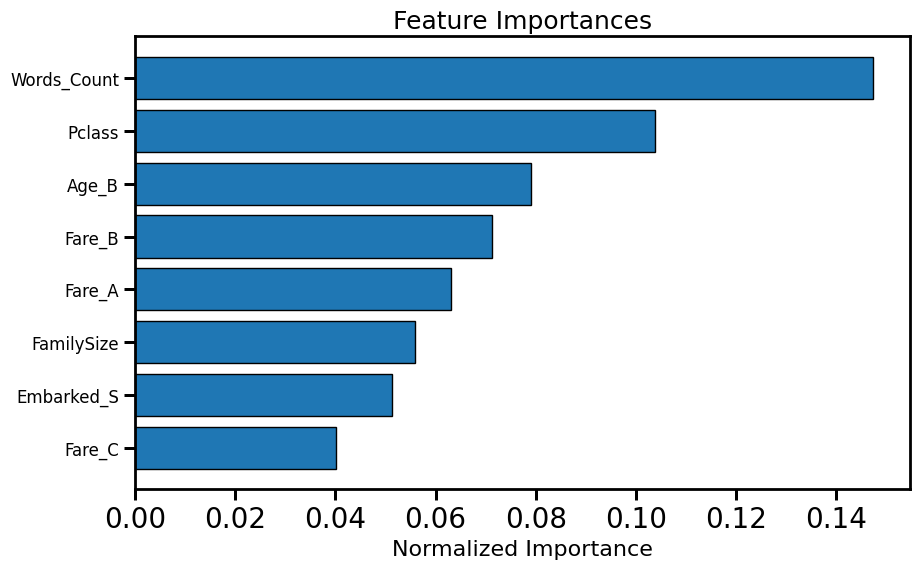

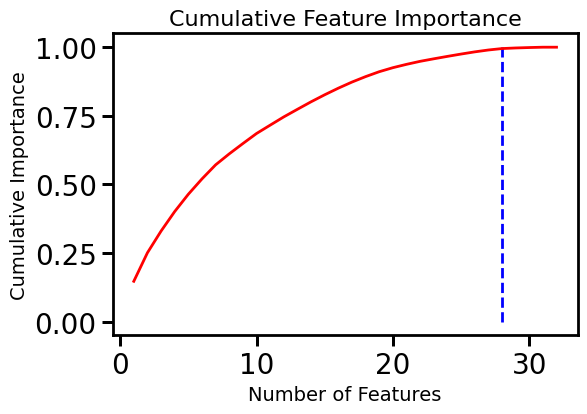

28 features required for 0.99 of cumulative importance


In [45]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 8)

In [46]:
# gather all identified features for for removal
remove = fs.check_removal()

Total of 4 features identified for removal


In [47]:
# Remove features suggested for Training and Testing data
X_train_data = X_train_data.drop(np.intersect1d(remove, X_train_data.keys()), axis=1)
X_test       = X_test.drop(np.intersect1d(remove, X_test.keys()), axis=1)

In [50]:
X_test  = data[len(train):]
X_test = X_test.drop(other_features[:2], axis=1)
X_test

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,...,Deck_None,Has_Cabin_No,Has_Cabin_Yes,PassengerId,Survived,Pclass,SibSp,Parch,FamilySize,Words_Count
891,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,892.0,666.0,3.0,0.0,0.0,1.0,3.0
892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,893.0,666.0,3.0,1.0,0.0,2.0,5.0
893,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,894.0,666.0,2.0,0.0,0.0,1.0,4.0
894,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,895.0,666.0,3.0,0.0,0.0,1.0,3.0
895,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,896.0,666.0,3.0,1.0,1.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1305.0,666.0,3.0,0.0,0.0,1.0,3.0
1305,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1306.0,666.0,1.0,0.0,0.0,1.0,5.0
1306,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1307.0,666.0,3.0,0.0,0.0,1.0,4.0
1307,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1308.0,666.0,3.0,0.0,0.0,1.0,3.0


# 3. Baseline CV = 5

In [52]:
for name, model in clfs.items():
    
    print("Classifier: {}".format(name))
    
    # compute benchmark

    results  = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
    results2 = cross_val_score(model, X_train_data, Y_train, scoring=make_scorer(f1_score, average='weighted'), cv=StratifiedKFold(n_splits=5) )
    
    print(r"Acc : ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))
    print(r"F1_w: ({:.2f} +- {:.2f})%".format( results2.mean() * 100, results2.std() * 100))
    print("")

Classifier: SGD
Acc : (78.45 +- 3.82)%
F1_w: (78.54 +- 3.61)%

Classifier: LR
Acc : (81.37 +- 2.04)%
F1_w: (81.30 +- 2.07)%

Classifier: DT
Acc : (79.91 +- 2.09)%
F1_w: (79.65 +- 2.25)%

Classifier: RF
Acc : (82.04 +- 2.58)%
F1_w: (81.87 +- 2.64)%

Classifier: KN
Acc : (82.04 +- 0.62)%
F1_w: (81.83 +- 0.65)%

Classifier: lgb
Acc : (82.60 +- 2.69)%
F1_w: (82.36 +- 2.87)%

Classifier: XGB
Acc : (80.92 +- 3.17)%
F1_w: (80.84 +- 3.20)%



In [ ]:
# Make predictions of a specific model

mod_name = 'lgb'
submission = utils.make_prediction(clfs[mod_name], X_train_data, Y_train, X_test) 

# Save predictions in desired format
submission.to_csv('submission_{}.csv'.format(mod_name), index=False)

In [ ]:
from sklearn.ensemble import VotingClassifier

named_estimators = [ 
                     ('DT', dtc),
                     ('RF', rfc),
                     ('lgb' , lgbw),
                     ('KN' , knc),
                     ('XGB' , xgbo)
                    ]

voting_clf = VotingClassifier(named_estimators,voting='soft')
voting_clf.fit(X_train_data, Y_train)

In [ ]:
results  = cross_val_score(voting_clf, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')

print(r"Acc : ({:.2f} +- {:.2f})%".format(  results.mean() * 100, results.std() * 100))
print("")